In [2]:
from ftplib import FTP
from io import BytesIO
from astropy.io import fits
import numpy as np
from scipy.interpolate import interp1d
from astropy.constants import sigma_sb, L_sun, M_sun, R_sun
from astropy.io import fits
from urllib.parse import urlparse
import astropy.units as u
import scipy.integrate
import matplotlib.pyplot as plt

# Galaxy ages from synthethic spectra : Part 1, SSP creation

The project involves generating a simplified version of SSPs, which will represent star clusters. Galaxies will be modeled as a collection of SSPs with a given SFH, meaning a galaxy will consist of different SSPs that were born at different times.

To create the SSPs, we will use spectra of representative stars from the Main Sequence (at least one spectrum for each spectral type OBAFGKM, Luminosity Class V), red giant stars (KM, Luminosity Class III), and the Horizontal Branch (G, Luminosity Class III). We will disregard the effects of metallicity on the spectra.

Stellar spectra is obtained from the ESO Stellar Library database.

Steps to Follow

	1.	Normalize Spectra: Normalize the spectra using the total luminosity of the stars. 
    2.      Star Formation and Evolution: Create a STAR class.
	3.	SFH for Galaxies: Each galaxy begins its existence at a very low redshift with a cloud composed 100% of gas.
	4.	Construct Galaxy Spectrum: Build the spectrum of the galaxy.

## Normalize Spectra

### Dependencies

In [1]:
from astropy.io import fits
from ftplib import FTP
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from urllib.parse import urlparse

c:\Users\ACER\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Code

Here we need tu obtain the spectra provided in the ESO Stellar Library. For this several functions are created.

"download_spectrum_ftp", finds the content of an file by a given url to the file. 
"open_fits_from_data" finds the geader and data from the fits.file downloaded by "download_spectrum_ftp".

Next, the spectrum obtained need to be normalized, then the following functions are made.

"calculate_total_luminosity", calculate the total luminosity of the spectrum. 
"normalize_spectrum_to_luminosity", normalize a stellar spectrum relative to the total luminosity

And in "normalize_spectrum_to_luminosity" the wavelengths and spectrum are truncated between 2450 Å and 10050 Å, as the data outside this range is modeled and not obtained form telescopes.

In [20]:
def download_spectrum_ftp(url):
    '''
        Downloads a file from an FTP server given a URL and returns its content.

    INPUTS:
    url (str): The FTP URL of the file to download. The URL should be in the format:
               'ftp://hostname/path/to/file'.

    OUTPUT:
    data: The content of the downloaded file.
    '''

    parsed_url = urlparse(url)
    ftp_host = parsed_url.hostname
    ftp_file_path = parsed_url.path

    ftp = FTP(ftp_host)
    ftp.login()

    file_data = BytesIO()
    ftp.retrbinary(f"RETR {ftp_file_path}", file_data.write)
    ftp.quit()

    file_data.seek(0)
    return file_data.read()


def open_fits_from_data(data):
    '''
        Opens a FITS file from binary data and extracts its header and data.

    This function takes the FITS file and returns the header and
    data of the primary HDU.

    INPUT:
    data (bytes): Binary data of the FITS file.

    OUTPUT:
    tuple: A tuple containing:
        - header: The header of the primary HDU.
        - data: The data of the primary HDU.
    '''
    with fits.open(BytesIO(data)) as hdul:
        header = hdul[0].header
        data = hdul[0].data
        return header, data


def calculate_total_luminosity(wavelength, spectrum):
    '''
        Calculates the total luminosity of a spectrum.

    This function uses numerical integration to calculate the total luminosity
    of a spectrum given the wavelength and flux data.

    INPUTS:
    wavelength (array-like): Array of wavelength values.
    spectrum (array-like): Array of flux values corresponding to the wavelengths.

    OUTPUT:
    float: The total luminosity of the spectrum.
    '''
    luminosity = np.trapz(spectrum, x=wavelength)
    return luminosity


def normalize_spectrum_to_luminosity(header, data):
    '''
    Normalizes a stellar spectrum relative to its total luminosity.

    This function takes the header and data of a FITS file, calculates the wavelength range,
    computes the total luminosity of the spectrum, and then normalizes the spectrum by dividing
    it by the total luminosity.

    INPUT:
    header (Header): The header of the primary HDU from a FITS file.
    data (array-like): The data (flux values) of the primary HDU from a FITS file.

    OUTPUT:
    tuple: A tuple containing:
        - wavelength (array-like): The calculated wavelength range.
        - normalized_spectrum (array-like): The normalized spectrum.
        - total_luminosity (float): The total luminosity of the spectrum.
    '''

    crpix1 = header['CRPIX1']  # Reference pixel
    crval1 = header['CRVAL1']  # Value of the reference pixel
    cdelt1 = header['CDELT1']  # Increment per pixel

    # Calculate the wavelength range
    wavelength = crval1 + (np.arange(len(data)) - crpix1 + 1) * cdelt1

    # Calculate the total luminosity of the spectrum
    total_luminosity = calculate_total_luminosity(wavelength, data)

    # Normalize the spectrum by dividing by the total luminosity
    normalized_spectrum = data / total_luminosity

    mask = (wavelength > 2450) & (wavelength < 10050)
    normalized_spectrum = normalized_spectrum[mask]
    wavelength = wavelength[mask]

    return wavelength, normalized_spectrum, total_luminosity, mask

### Visualization

In [15]:
# Intrinsic luminosity dictionary

intrinsic_lum = {
    'O5': 846000, 'O9': 95000,
    'B0': 20000, 'B1': 4600,
    'A0': 22, 'A2': 18,
    'F0': 4.3, 'F2': 3.3,
    'G0': 1.3, 'G2': 1,
    'K0': 0.54, 'K2': 0.38,
    'M0': 0.069, 'M1': 0.064
}

# Spectra URLs dictionary with explicit spectral type
spectra_urls = {
    "O5": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko5v.fits",
    "O9": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko9v.fits",
    "B0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb0v.fits",
    "B1": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb1v.fits",
    "A0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka0v.fits",
    "A2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka2v.fits",
    "F0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf0v.fits",
    "F2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf2v.fits",
    "G0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg0v.fits",
    "G2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg2v.fits",
    "K0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk0v.fits",
    "K2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk2v.fits",
    "M0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm0v.fits",
    "M1": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm1v.fits"
}

# Spectra URLs dictionary with explicit spectral type for red giant and horizontal branches
spectra_branch_urls = {
    'G5': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukg5iii.fits',
    'G8': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukg8iii.fits',
    'K0': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukk0iii.fits',
    'K1': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukk0iii.fits',
    'K2': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukk2iii.fits',
    'M4': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukm4iii.fits',
    'M2': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukm2iii.fits',
    'M6': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukm6iii.fits'
}

# Download the spectra data
spectra = {key: download_spectrum_ftp(url) for key, url in spectra_urls.items()}
spectra_branch = {key: download_spectrum_ftp(url) for key, url in spectra_branch_urls.items()}

### Example of usage

In [22]:
# To obtain the header of data of Spectra O5
header_O, data_O = open_fits_from_data(spectra['O5'])

# Normalize the spectrum
wavelength_O, normalized_spectrum_O, total_luminosity_O, mask_O = normalize_spectrum_to_luminosity(header_O, data_O)

# The same for Spectra of  
header_K, data_K = open_fits_from_data(spectra['K2'])
wavelength_K, normalized_spectrum_K, total_luminosity_K, mask_K = normalize_spectrum_to_luminosity(header_K, data_K)

0.11383453
0.16155486
0.0814439


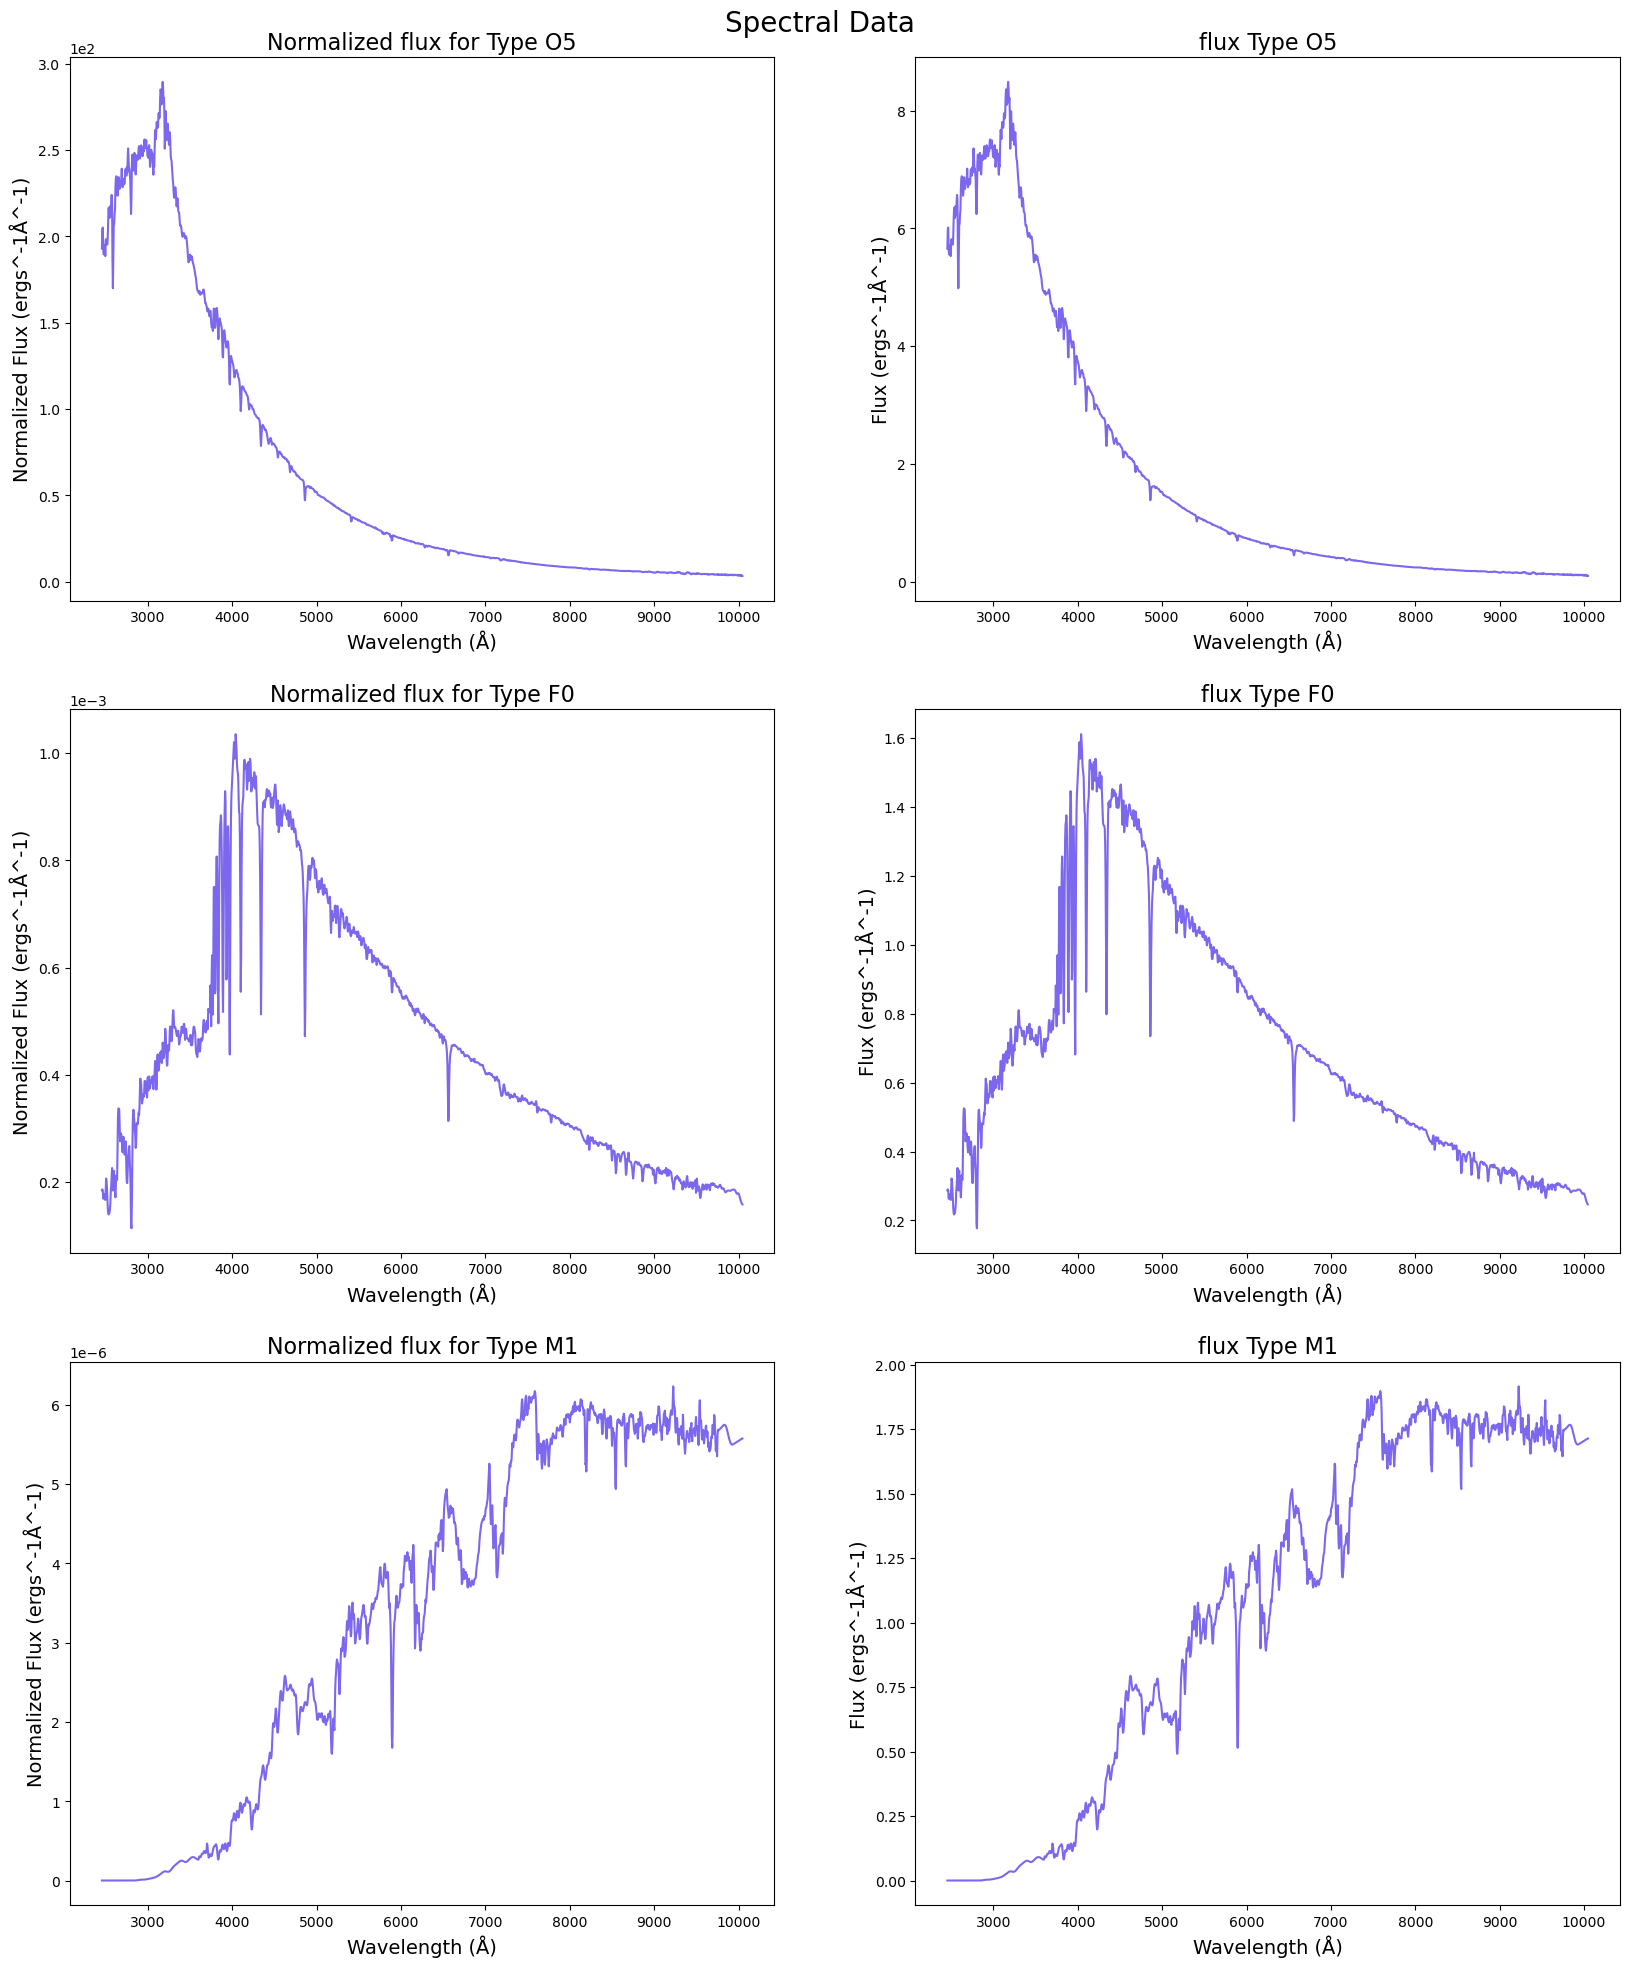

In [533]:
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
examples_types = ('O5', 'F0', 'M1')
axes = axes.flatten()
for spectral_type, i in zip(examples_types, range(0, 6, 2)):
    fits_data = spectra[spectral_type]
    header, data = open_fits_from_data(fits_data)

    # Normalize the spectrum relative to the luminosity
    wavelength, normalized_spectrum, total_luminosity, mask = normalize_spectrum_to_luminosity(header, data)

    # Get the intrinsic luminosity
    intrinsic_luminosity = intrinsic_lum[spectral_type]

    # Multiply the normalized spectrum by the intrinsic luminosity
    intrinsic_normalized_spectrum = normalized_spectrum * intrinsic_luminosity

    # Plot the spectrum
    axes[i].plot(wavelength,
             intrinsic_normalized_spectrum,
             color='mediumslateblue')
    axes[i].set_xlabel('Wavelength (Å)', fontsize=14)
    axes[i].set_ylabel('Normalized Flux (ergs^-1Å^-1)', fontsize=14)
    axes[i].set_title(f'Normalized flux for Type {spectral_type}', fontsize=16)
    axes[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

    data = data[mask]
    axes[i+1].plot(wavelength,
             data,
             color='mediumslateblue')
    axes[i+1].set_xlabel('Wavelength (Å)', fontsize=14)
    axes[i+1].set_ylabel('Flux (ergs^-1Å^-1)', fontsize=14)
    axes[i+1].set_title(f'flux Type {spectral_type}', fontsize=16)
    axes[i+1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

plt.suptitle('Spectral Data', y=0.9, fontsize=20)
plt.savefig('compare_spectra.pdf', format='pdf')
plt.show()

From the plots for three different spectral types is plausible to note that the spectrum are well normalized as the y-axis changes while the behaviour of the plot remain the same.

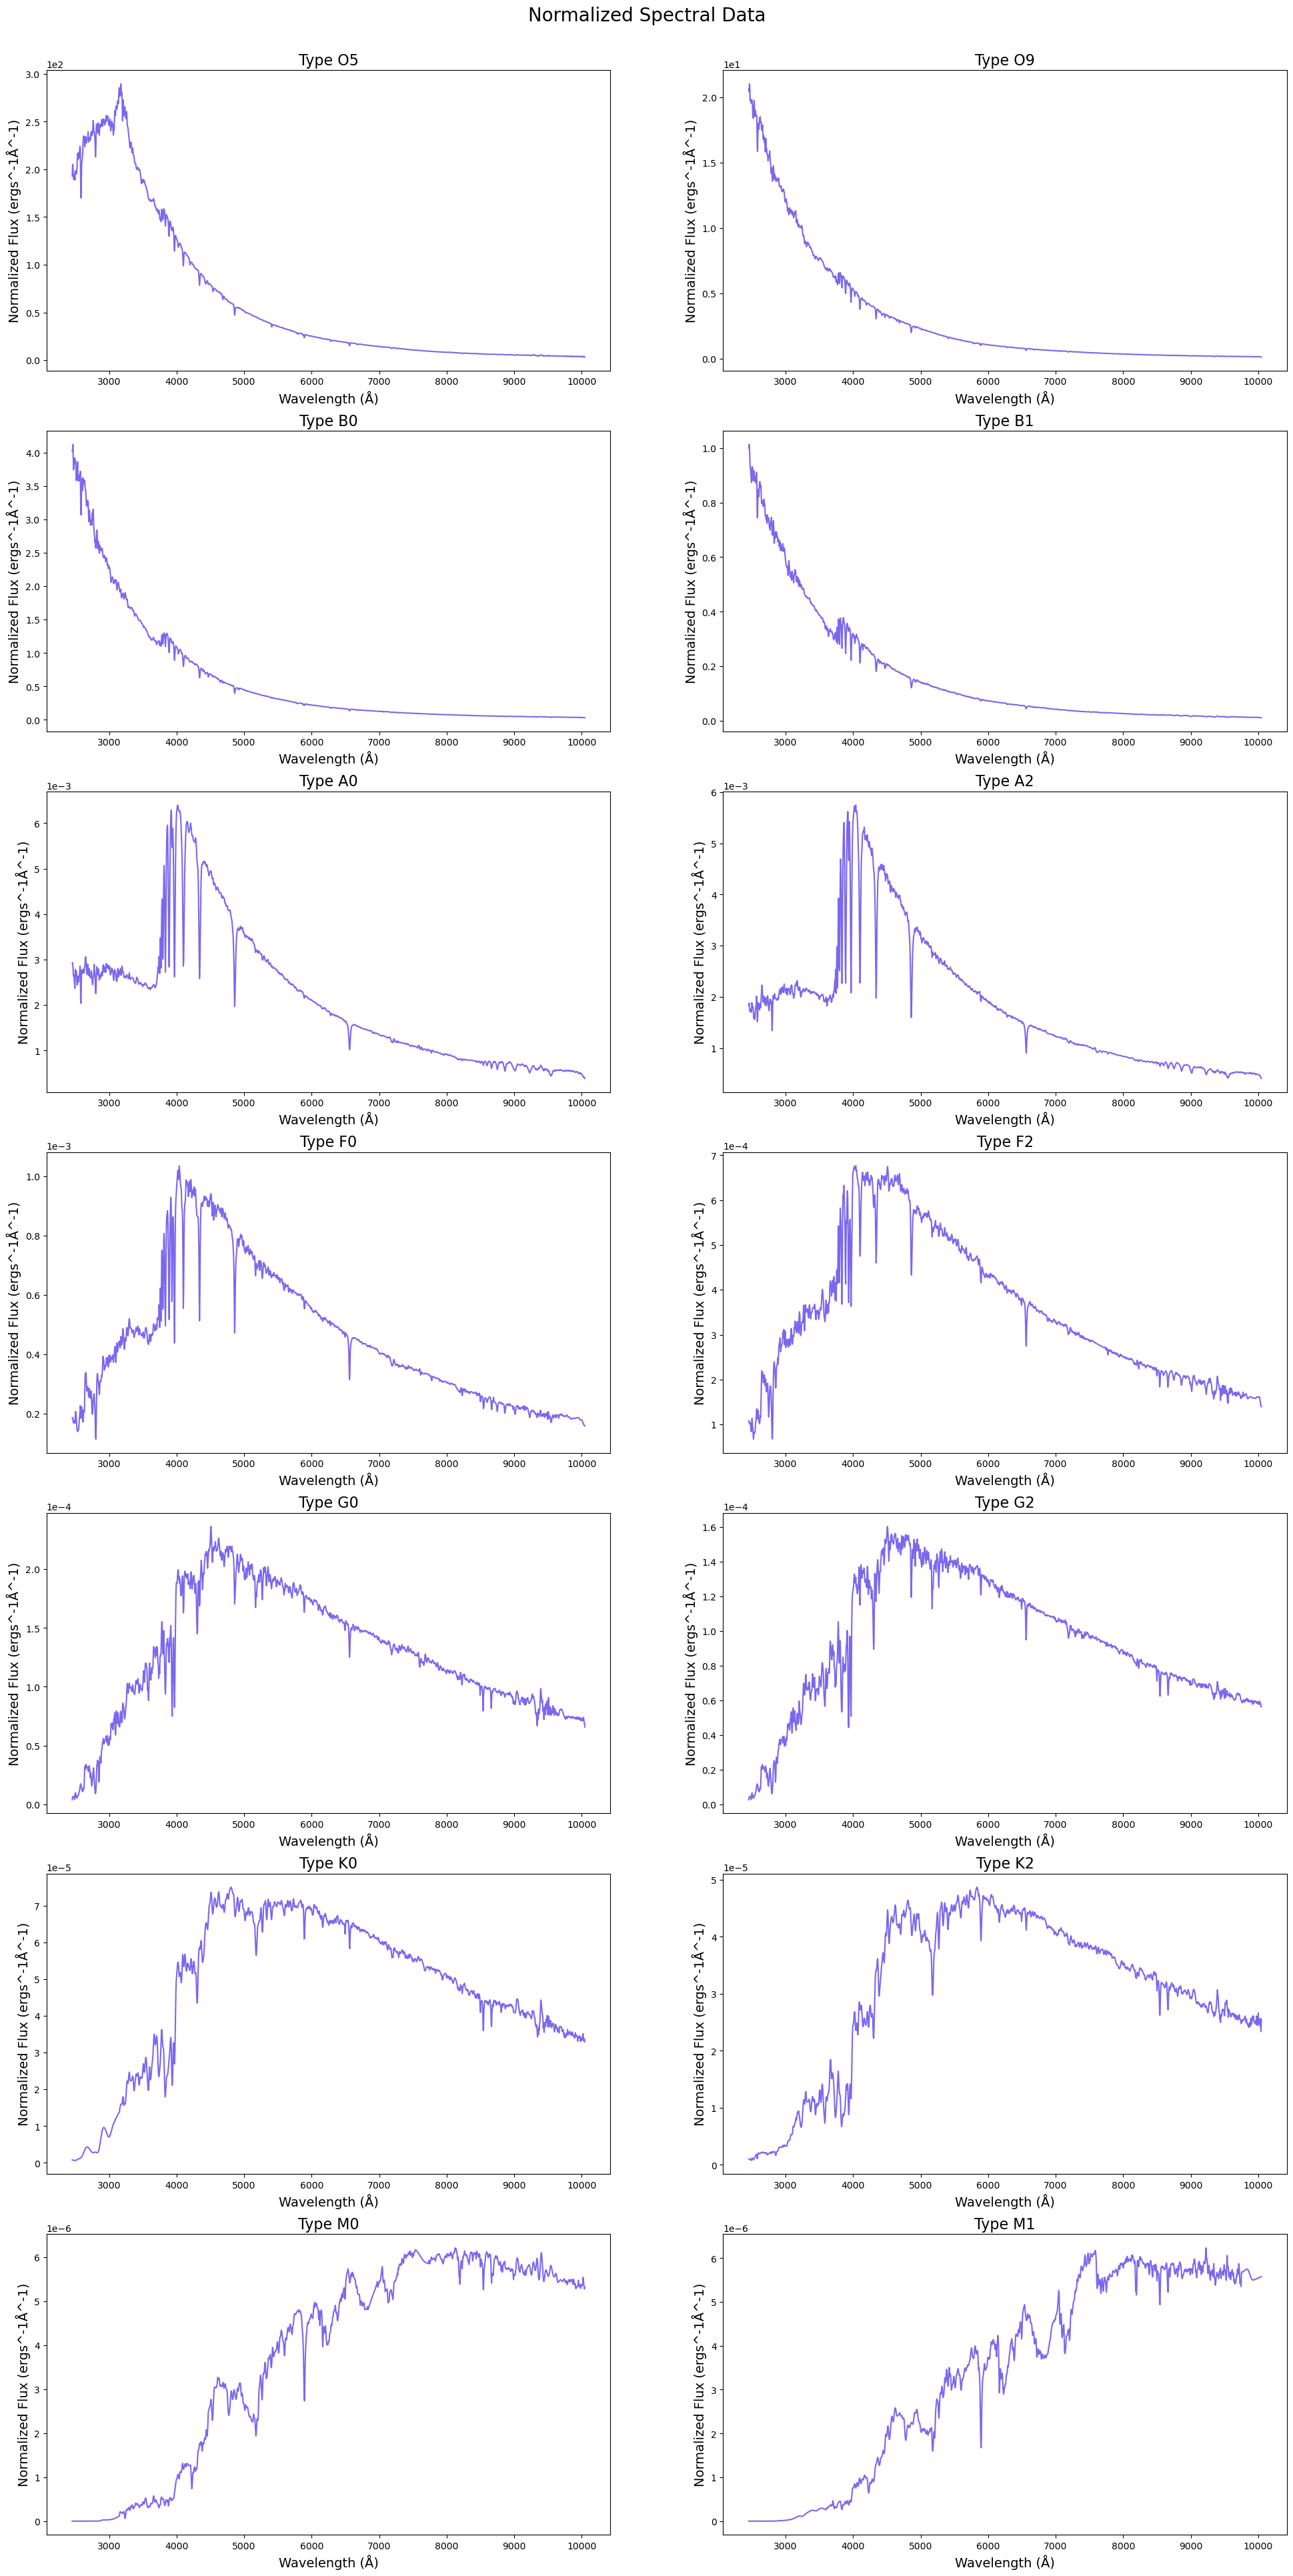

In [526]:
fig, axes = plt.subplots(7, 2, figsize=(24, 48))
axes = axes.flatten()

for (spectral_type, fits_data), ax in zip(spectra.items(), axes):
    # Obtain the header and data from the FITS file
    header, data = open_fits_from_data(fits_data)

    # Normalize the spectrum relative to the luminosity
    wavelength, normalized_spectrum, total_luminosity, _ = normalize_spectrum_to_luminosity(header, data)

    # Get the intrinsic luminosity
    intrinsic_luminosity = intrinsic_lum[spectral_type]

    # Multiply the normalized spectrum by the intrinsic luminosity
    intrinsic_normalized_spectrum = normalized_spectrum * intrinsic_luminosity

    # Plot the spectrum
    ax.plot(wavelength,
             intrinsic_normalized_spectrum,
             color='mediumslateblue')
    ax.set_xlabel('Wavelength (Å)', fontsize=14)
    ax.set_ylabel('Normalized Flux (ergs^-1Å^-1)', fontsize=14)
    ax.set_title(f'Type {spectral_type}', fontsize=16)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

plt.suptitle('Normalized Spectral Data', y=0.9, fontsize=20)
plt.savefig('norm_spectra.pdf', format='pdf')
plt.show()


This plot represent every star spectrum that will be used for the star class and the creation of stars and consequently the galaxy sspectrum 

## Star Class

### Dependencies

In [535]:
from astropy.constants import sigma_sb, L_sun, M_sun, R_sun
from astropy.io import fits
import astropy.units as u
from io import BytesIO
import numpy as np

### Code

In [28]:

class STAR:
    """
    A class to represent a star and simulate its evolution through different stages.
    """
    def __init__(self, mass, born, weight):
        """
        INPUTS:
        mass (float): The mass of the star in solar masses.
        born (float): The birth time of the star in Gyr (gigayears).
        """

        global spectra
        global spectra_branch

        self.spectra = spectra
        self.spectra_branch = spectra_branch

        self.weight = weight
        # Initial mass of the star
        self.mass = mass*M_sun

        # Time in main sequence
        cons = (10 * u.Gyr) * M_sun**3
        self.t_ms = cons / ((self.mass)**3)

        # Time on which the star was born
        self.born = born * u.Gyr
        self.stage = self.born

        # Initial branch at born stage
        self.branch = 'MS'

        # Get T, L, spectral type and spectrum
        self.properties()
        self.get_star_spectrum(self.spectra)


    def properties(self):
        """
        Set the T, L and spectral type of the star based on its mass using the mass-luminosity relation
        and the Stefan-Boltzmann law.
        """
        # Using Mass-Luminosity relation
        if self.mass/M_sun < 0.43:
            self.luminosity = 0.23 * ((self.mass/M_sun) ** 2.3) * L_sun
        elif 0.43 <= self.mass/M_sun < 2.0:
            self.luminosity = ((self.mass/M_sun) ** 4.0) * L_sun
        elif 2.0 <= self.mass/M_sun < 55:
            self.luminosity = 1.4 * L_sun * ((self.mass/M_sun) ** 3.5)
        elif 55 <= self.mass/M_sun:
            self.luminosity = 32000 * (self.mass/M_sun) * L_sun

        # Using Stafan-Boltzmann law
        sigma = sigma_sb.to(u.W / (u.m**2 * u.K**4))
        self.radii = R_sun * (self.mass / M_sun)**0.8
        denominator = (4 * np.pi * (self.radii**2) * sigma)
        self.temperature = ((self.luminosity / denominator) ** 0.25)

        # Spectral type classification
        if (self.mass/M_sun) > 16:
            self.spectral_type = 'O'
        elif (self.mass/M_sun) > 2.1:
            self.spectral_type = 'B'
        elif (self.mass/M_sun) > 1.4:
            self.spectral_type = 'A'
        elif (self.mass/M_sun) > 1.04:
            self.spectral_type = 'F'
        elif (self.mass/M_sun) > 0.8:
            self.spectral_type = 'G'
        elif (self.mass/M_sun) > 0.45:
            self.spectral_type = 'K'
        else:
            self.spectral_type = 'M'

    def read_spectrum_from_fits(self, data):
        """
        Read the spectrum from a FITS file.

        INPUT:
        data (bytes): The binary data of the FITS file.

        OUTPUT:
        tuple: A tuple containing the wavelength array and the spectrum data array.
        """
        with fits.open(BytesIO(data)) as hdul:
            header = hdul[0].header
            spectrum_data = hdul[0].data

            wavelengths = np.arange(header['CRVAL1'],
                                    header['CRVAL1'] + header['CDELT1'] * len(spectrum_data),
                                    header['CDELT1'])
            return wavelengths[:len(spectrum_data)], spectrum_data

    def get_star_spectrum(self, spectra_to_use):
        """
        Get the star's spectrum based on its spectral type.

        INPUT:
        spectra_to_use (dict): The dictionary of available spectra.
        """
        new_type = [type for type in list(spectra_to_use) if type.startswith(self.spectral_type)]
        new_spectral_type = np.random.choice(new_type)
        self.spectral_type = new_spectral_type

        if new_spectral_type in spectra_to_use:

            data = spectra_to_use[new_spectral_type]
            self.wavelengths, self.spectrum = self.read_spectrum_from_fits(data)

            self.total_lum = np.trapz(self.spectrum, x=self.wavelengths)

            self.flux = self.spectrum / self.total_lum
            mask = (self.wavelengths < 10050) & (self.wavelengths > 2450)
            self.wavelength = self.wavelengths[mask]
            self.spectrum = self.spectrum[mask]
            self.flux = self.flux[mask]

        else:
            raise ValueError(f"Spectral type {new_spectral_type} not available in spectra.")

    def plot(self):
        """
        Plot the star's normalized spectrum.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.wavelength,
                    self.flux,
                    color='mediumslateblue')
        plt.xlabel('Wavelength (Å)')
        plt.ylabel('Normalized Flux (ergs^-1Å^-1)') # ergs−1A−1
        plt.title(f'Normalized Spectral Data - Type {self.spectral_type} - branch {self.branch}')
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        plt.show()

    def new_properties(self):
        """
        Update the properties of the star for different branches (RG, HB).
        """
        assert self.branch == 'RG' or self.branch == 'HB', f"Branch must be 'RG' or 'HB', but got {self.branch}"
        new_proper = {
            'G5': (5010 * u.K, 127 * L_sun),
            'G8': (4870 * u.K, 113 * L_sun),
            'K0': (4720 * u.K, 96 * L_sun),
            'K1': (4580 * u.K, 82 * L_sun),
            'K2': (4460 * u.K, 70 * L_sun),
            'M2': (3500 * u.K, 11 * L_sun),
            'M4': (3100 * u.K, 7.4 * L_sun),
            'M6': (2800 * u.K, 3.3 * L_sun),
        }
        self.temperature, self.luminosity = new_proper[self.spectral_type]

    
    def update(self, t):
        """
        Update the star's properties based on its age and evolutionary stage.

        Parameters:
        t (float): The current age of the universe in Gyr (gigayears).
        """
        # T es edad del universo!

        # Star life (T_universe - T_born)
        life = t - self.stage
        self.stage = t

        # Time in horizontal branch
        HB_life = 1 *u.Gyr + 1*u.Myr

        if life.value < 0:
            self.branch = 'Unborn Star'
            self.flux = np.zeros(self.spectrum.shape)

        elif life.value > 0. and self.branch == 'Unborn Star':
            self.branch = 'MS'
            self.properties()
            self.get_star_spectrum(self.spectra)

        elif (self.mass/M_sun) < 5:
            # Outside of main sequence
            if life > self.t_ms:
                # In time of Red giant branch
                if life - self.t_ms < 1 * u.Gyr:
                    # First time at RG branch
                    if self.branch == 'MS' or self.branch == 'Unborn Star':
                        self.branch = 'RG'
                        self.spectral_type = 'K'
                        self.get_star_spectrum(self.spectra_branch)
                        self.new_properties()
                        self.spectrum = self.spectrum * (self.luminosity/L_sun) * self.weight

                    # Second time ar RG branch
                    elif self.branch == 'RG':
                        self.spectral_type = 'M'
                        self.get_star_spectrum(self.spectra_branch)
                        self.new_properties()
                        self.spectrum = self.spectrum * (self.luminosity/L_sun) * self.weight

                elif life - self.t_ms < HB_life:
                    self.branch = 'HB'
                    self.spectral_type = 'G'
                    self.get_star_spectrum(self.spectra_branch)
                    self.new_properties()
                    self.spectrum = self.spectrum * (self.luminosity/L_sun) * self.weight

                else:
                    self.branch = 'Dead'
                    self.spectral_type = 'Dead'
                    self.flux = np.zeros(self.spectrum.shape)
        else:
            if life > self.t_ms:
                self.branch = "Dead"
                self.spectral_type = 'Dead'
                self.flux = np.zeros(self.spectrum.shape)

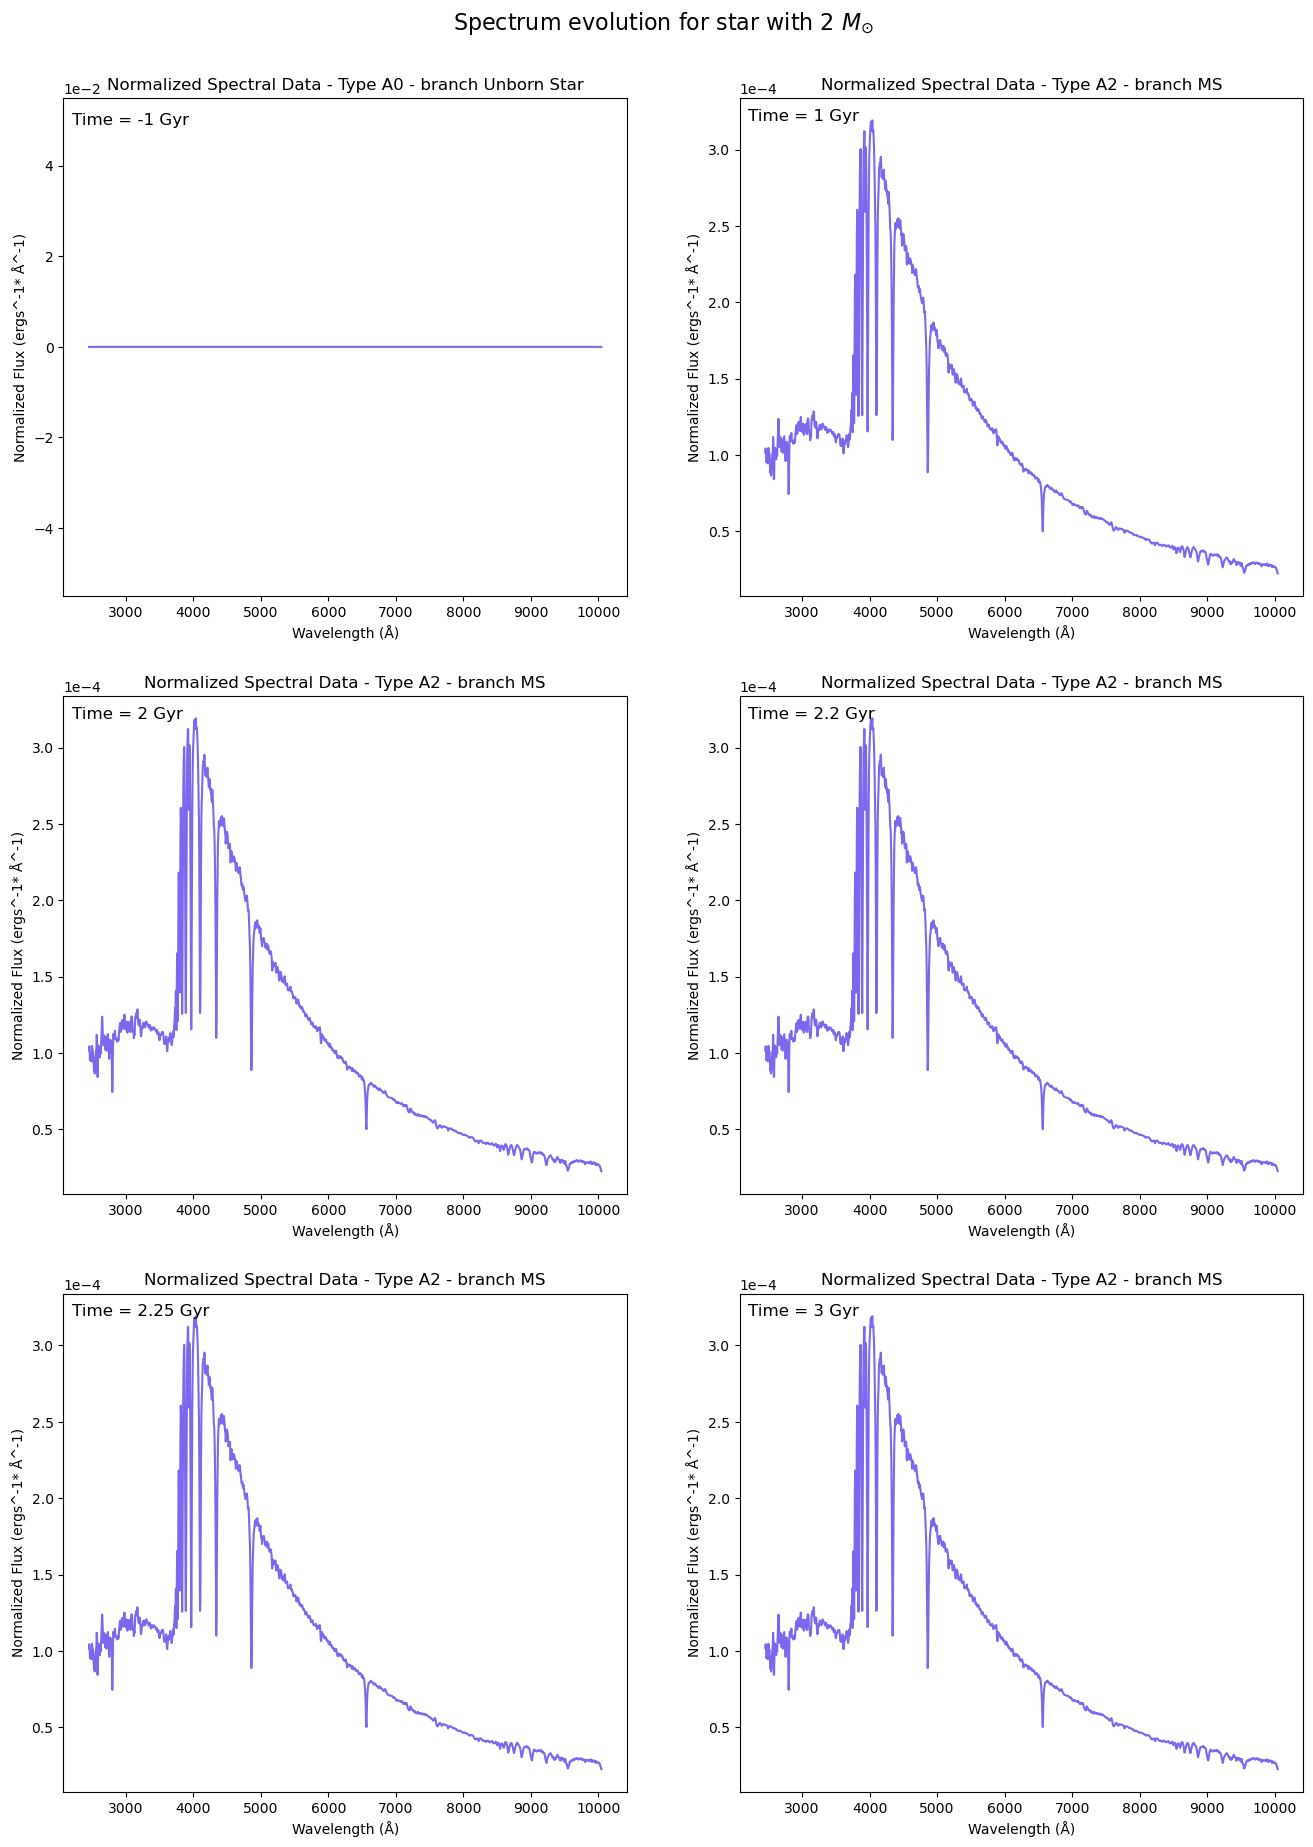

In [29]:
#Plot star evolution

fig , axes = plt.subplots(3, 2, figsize=(16, 22))
axes = axes.flatten()
star = STAR(2, 0, 1)
times = (-1, 1, 2, 2.2, 2.25, 3)
for ax, time in zip(axes, times):
    star.update(time * u.Gyr)
    ax.plot(star.wavelength,
                star.flux,
                color='mediumslateblue')
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Normalized Flux (ergs^-1* Å^-1)')
    ax.set_title(f'Normalized Spectral Data - Type {star.spectral_type} - branch {star.branch}')
    if np.max(star.flux) == 0.:
        ax.text(2.2e3, 4.9e-2, f'Time = {time} Gyr', fontsize=12)
    else:
        ax.text(2.2e3, np.max(star.flux), f'Time = {time} Gyr', fontsize=12)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

plt.suptitle('Spectrum evolution for star with 2 ' + r'$M_{\odot}$', y=0.92, size=16)
plt.savefig('spectra_evo.pdf', format='pdf')
plt.show()

With this the STAR class evolve the spectrum within the branches and gives the death of the star with flux 0 

In [596]:
star = STAR(1,0,1)

In [597]:
star.update(-1 *u.Gyr)

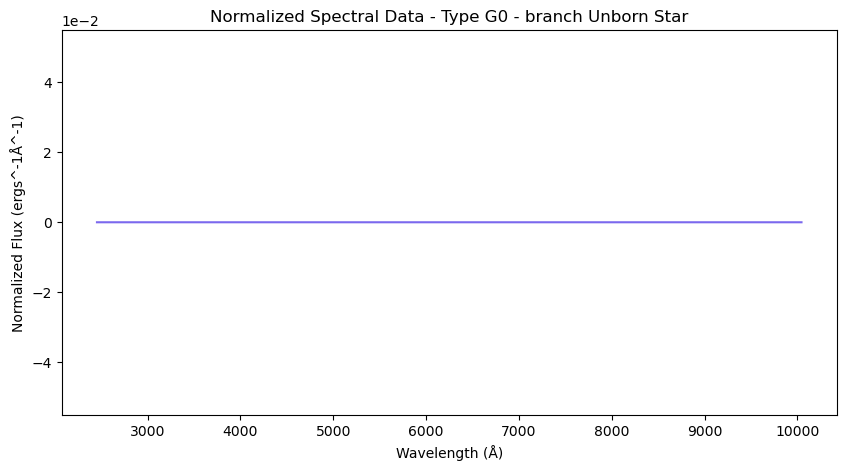

In [598]:
star.plot()

In [599]:
star.update(1*u.Gyr)

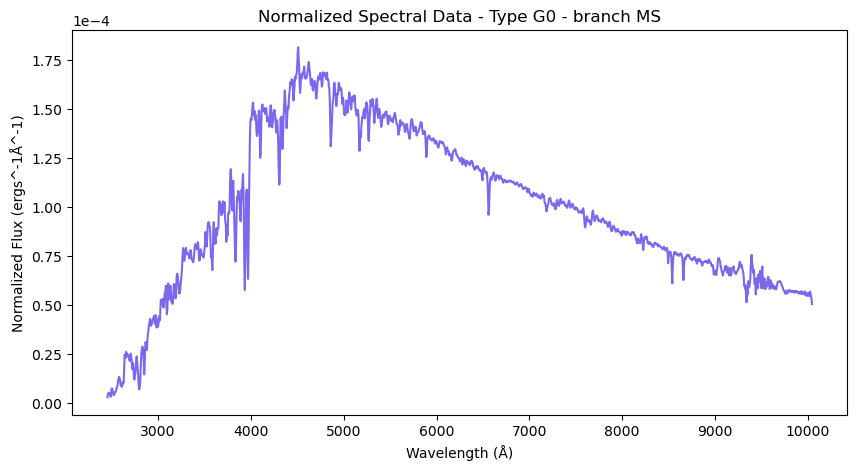

In [600]:
star.plot()

## IMF CLASS

### Dependencies

In [3]:
import numpy as np
from scipy.interpolate import interp1d
from astropy.constants import sigma_sb, L_sun, M_sun, R_sun
from astropy.io import fits
import astropy.units as u
import scipy.integrate
import matplotlib.pyplot as plt

### Code

In [4]:


import scipy


class IMF_salpeter:
    """
    A class to create the Salpeter Initial Mass Function (IMF).

    The Salpeter IMF is used to describe the distribution of stellar masses 
    at the time of star formation. It is defined by a power-law distribution 
    with a specific slope.

    Attributes:
    ----------
    default_mmin : float
        The default minimum mass for the IMF (default is 0.3 solar masses).
    default_mmax : float
        The default maximum mass for the IMF (default is 120 solar masses).

    Methods:
    -------
    __init__(alpha=2.35, mmin=None, mmax=None):
        Initializes the IMF with a specified slope and mass range.
    pdf(x):
        Returns the probability density function value at mass x.
    __call__(m):
        Returns the normalized IMF value at mass m.
    generate_masses(min_mass, max_mass, e=1):
        Generates masses according to the Salpeter IMF within a given range.
    generate_mass_range(delta):
        Generates a range of masses from mmin to mmax with a specified delta step.
    imf_fraction(mass_list, e=1):
        Computes the fraction of the IMF within each bin of a given mass list.
    generate_imf(delta, e=1):
        Generates the IMF fractions over a specified mass range with a given step size.
    """
    default_mmin = 0.3
    default_mmax = 120

    def __init__(self, alpha=2.35, mmin=None, mmax=None):
        """
        Initializes the IMF with a specified slope and mass range.

        Parameters:
        ----------
        alpha : float, optional
            The slope of the IMF (default is 2.35).
        mmin : float, optional
            The minimum mass for the IMF (default is 0.3 solar masses).
        mmax : float, optional
            The maximum mass for the IMF (default is 120 solar masses).
        """
        self._mmin = self.default_mmin if mmin is None else mmin
        self._mmax = self.default_mmax if mmax is None else mmax
        self.alpha = alpha
        self.slope = -alpha

        assert self._mmin < self._mmax, "Minimum mass must be less than maximum mass."
        assert self._mmin > 0, "Minimum mass must be greater than zero."
        assert self._mmin != -1, "Minimum mass cannot be -1."

    def pdf(self, x):
        """
        Returns the probability density function value at mass x.

        Parameters:
        ----------
        x : float
            The mass at which to evaluate the PDF.

        Returns:
        -------
        float
            The PDF value at mass x.
        """
        is_in_range = (x >= self._mmin) & (x <= self._mmax)
        return x**self.slope * is_in_range

    def __call__(self, m):
        """
        Returns the normalized IMF value at mass m.

        Parameters:
        ----------
        m : float
            The mass at which to evaluate the IMF.

        Returns:
        -------
        float
            The normalized IMF value at mass m.
        """
        integral, _ = scipy.integrate.quad(self.pdf, self._mmin, self._mmax)
        return self.pdf(m) / integral

    def generate_masses(self, min_mass, max_mass, e=1):
        """
        Generates masses according to the Salpeter IMF within a given range.

        Parameters:
        ----------
        min_mass : float
            The minimum mass for the range.
        max_mass : float
            The maximum mass for the range.
        e : float, optional
            Exponent for the mass generation formula (default is 1).

        Returns:
        -------
        float
            The generated masses according to the Salpeter IMF.
        """
        cte = 1.35
        return ((min_mass**-cte) - (max_mass**-cte)) * (e / cte)

    def generate_mass_range(self, delta):
        """
        Generates a range of masses from mmin to mmax with a specified delta step.

        Parameters:
        ----------
        delta : float
            The step size for the mass range.

        Returns:
        -------
        numpy.ndarray
            The generated mass range.
        """
        return np.arange(self._mmin, self._mmax + delta, delta)

    def imf_fraction(self, mass_list, e=1):
        """
        Computes the fraction of the IMF within each bin of a given mass list.

        Parameters:
        ----------
        mass_list : list of float
            The list of mass bins.
        e : float, optional
            Exponent for the mass generation formula (default is 1).

        Returns:
        -------
        numpy.ndarray
            The fraction of the IMF within each mass bin.
        """
        tot = self.generate_masses(mass_list[0], mass_list[-1], 1)
        frac = np.zeros_like(mass_list[0:-1])
        
        for i in range(len(mass_list) - 1):
            frac[i] = self.generate_masses(mass_list[i], mass_list[i + 1], e)

        return frac / tot

    def generate_imf(self, delta, e=1):
        """
        Generates the IMF fractions over a specified mass range with a given step size.

        Parameters:
        ----------
        delta : float
            The step size for the mass range.
        e : float, optional
            Exponent for the mass generation formula (default is 1).

        Returns:
        -------
        tuple
            A tuple containing the mass range and the corresponding IMF fractions.
        """
        mass_range = self.generate_mass_range(delta)
        fractions = self.imf_fraction(mass_range, e)
        return mass_range, fractions


Ejempo de Uso  

Mass Range: [  0.3   0.4   0.5 ... 119.8 119.9 120. ]
Fractions: [3.21938017e-01 1.76445597e-01 1.09510995e-01 ... 3.47242967e-07
 3.46562482e-07 3.45883896e-07]


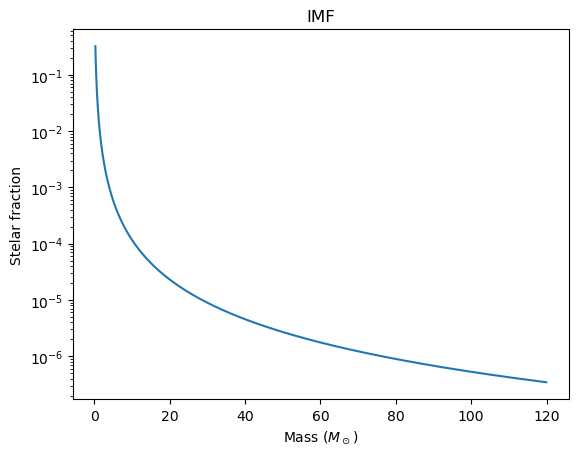

In [5]:
imf = IMF_salpeter()
delta = 0.1
mass_range, fractions = imf.generate_imf(delta)

print("Mass Range:", mass_range)
print("Fractions:", fractions)

# Plot the IMF
plt.plot(mass_range[:-1], fractions)
plt.yscale('log')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Stelar fraction')
plt.title('IMF')
plt.show()

## Class GALAXY

In [37]:
from ftplib import FTP
from io import BytesIO
from astropy.io import fits
import numpy as np
from scipy.interpolate import interp1d
from astropy.constants import sigma_sb, L_sun, M_sun, R_sun
from astropy.io import fits
from urllib.parse import urlparse
import astropy.units as u
import scipy.integrate
import matplotlib.pyplot as plt

Methods:
    -------
    __init__(min_mass, max_mass):
        Initializes the galaxy with a given mass range for star formation.
    Star_Formation(t, delta, e):
        Simulates the star formation process at a given time with specified IMF parameters.
    update_gal(t):
        Updates the galaxy's spectrum based on the current time.
    organization(org):
        Groups stars by their spectral type.
    ratio_Spectrum(rang):
        Calculates the ratio of the spectrum within a specified wavelength range for different spectral types.
    plot_star_formation_rates():
        Plots the star formation rates over the galaxy's ages.
    set_star_formation_rates(SFR, ages):


 stars : list
        A list of STAR objects representing the stars in the galaxy.
    imf : IMF_salpeter
        The initial mass function used for star formation.
    spectrum : numpy.ndarray
        The combined spectrum of all stars in the galaxy.
    t : float or None
        The current time in the galaxy's evolution (in Gyr).
    SFR : list or None
        The star formation rates over different ages.
    ages : list or None
        The ages corresponding to the star formation rates.

    Sets the star formation rates and ages for the galaxy.
        

In [49]:
class GALAXY:
    """
    A class to represent a galaxy, including its star formation process,
    spectral evolution, and star formation rates.

    INPUTS: 
    ----------
    minMass (float) : The minimum mass for star formation in the galaxy.
    maxMass (float) : The maximum mass for star formation in the galaxy.
    """
    def __init__(self, min_mass, max_mass):
        """
        Initializes the galaxy with a given mass range for star formation.

        Parameters:
        ----------
        min_mass : float
            The minimum mass for star formation in the galaxy.
        max_mass : float
            The maximum mass for star formation in the galaxy.
        """
        self.stars = []
        self.minMass = min_mass
        self.maxMass = max_mass
        self.imf = IMF_salpeter(mmin=min_mass, mmax=max_mass)
        self.spectrum = np.zeros_like(STAR(1, 0, 1).flux)
        self.t = None
        self.SFR = None
        self.ages = None
    
    def Star_Formation(self, t, delta, e):
        """
        Simulates the star formation process at a given time with specified IMF parameters.
        """
        mlist, fractions = self.imf.generate_imf(delta, e)
        for i in range(len(mlist) - 1):
            star = STAR(mlist[i], t, fractions[i])
            self.stars.append(star)
            self.spectrum += star.flux
    
    def update_gal(self, t):
        """
        Updates the galaxy's spectrum based on the current time.
        """
        global wavelength_O
        tot = np.zeros_like(wavelength_O)
        for star in self.stars:
            star.update(t * u.Gyr)
            tot += star.flux
        
        self.spectrum = tot
        self.t = t
    
    def organization(self, org):
        """
        Groups stars by their spectral type.
        """
        group = []
        for star in self.stars:
            type = star.spectral_type
            if type == org:
                group.append(star)
        return group
    
    def ratio_Spectrum(self, rang):
        """
        Calculates the ratio of the spectrum within a specified wavelength range for different spectral types.
        """
        global spectral_types
        global wavelength_O

        def range_lb(list, rang):
            return (list >= rang[0]) * (list <= rang[1])
        
        rango = range_lb(wavelength_O, rang)
        ratios = []
        for type in spectral_types:
            group = self.organization(type)
            f = 0
            for star in group:
                f += np.sum(star.spectrum[rango])
            
            ratios.append(f)
        tot = np.sum(ratios)
        return ratios / tot
    
    def plot_SFR(self):
        """
        Plots the star formation rates over the galaxy's ages.
        """
        if self.SFR is None or self.ages is None:
            raise ValueError("Star formation rates (SFR) and ages have not been set.")
        
        plt.bar(self.ages, self.SFR, width=0.5,
                align='center', alpha=0.7, color='mediumslateblue')
        plt.xlabel('Age (Gyr)')
        plt.ylabel('Star Formation Rate')
        plt.title('Star Formation Rates over Galaxy Ages')
        plt.xlim(0, np.max(self.ages))
        plt.ylim(0, 1.01)
        plt.grid(True)
        plt.show()
    
    def set_SFR(self, SFR, ages):
        """
        Sets the star formation rates and ages for the galaxy.
        """
        self.SFR = SFR
        self.ages = ages
    def modeldisplay(self, SFR, t):
        """
        Simulates the galaxy evolution and displays the spectrum at different times.

        This method creates a galaxy model, simulates star formation at specified times
        with given star formation rates (SFR), and then displays the normalized galaxy
        spectrum at selected times.
        """

        def displayGG(gal, t, rang=[2500, 10000]):
            """
            Displays the galaxy spectrum at different times.
            """
            global wavelength_O

            range_lb = (wavelength_O >= rang[0]) & (wavelength_O <= rang[1])

            for i in range(len(t)):
                gal.update_gal(t[i])
                normalized_flux = gal.spectrum / np.max(gal.spectrum[range_lb])  # Normalize flux
                plt.plot(wavelength_O[range_lb], normalized_flux[range_lb],
                         label=f'T={t[i]} Gyr', color='mediumslateblue')
                plt.xlabel('Wavelength (Å)')
                plt.ylabel('Normalized Flux (ergs^-1* Å^-1)')
                plt.title('Galaxy Spectrum')
                plt.legend()
                plt.show()

        tanalysis = [5, 8, 11, 14]

        for i in range(len(SFR)):
            self.Star_Formation(t[i], 0.1, SFR[i])

        displayGG(self, tanalysis)
        return self.spectrum


In [38]:

def modeldisplay(SFR, t):
    """
    Simulates the galaxy evolution and displays the spectrum at different times.

    This function creates a galaxy model, simulates star formation at specified times
    with given star formation rates (SFR), and then displays the normalized galaxy
    spectrum at selected times.
    """

    def displayGG(gal, t, rang=[2500, 10000]):
        """
        Displays the galaxy spectrum at different times.
        """
        global wavelength_O

        range_lb = (wavelength_O >= rang[0]) & (wavelength_O <= rang[1])

        for i in range(len(t)):
            gal.update_gal(t[i])
            normalized_flux = gal.spectrum / np.max(gal.spectrum[range_lb])  # Normalize flux
            plt.plot(wavelength_O[range_lb], normalized_flux[range_lb],
                     label=f'T={t[i]} Gyr', color='mediumslateblue')
            plt.xlabel('Wavelength (Å)')
            plt.ylabel('Normalized Flux (ergs^-1* Å^-1)')
            plt.title(f'Galaxy Spectrum at {t[i]*u.Gyr}')
            plt.legend()
            plt.show()

    tanalysis = [5, 8, 11, 14]

    gal = GALAXY(min_mass=0.1, max_mass=100)

    for i in range(len(SFR)):
        gal.Star_Formation(t[i], 0.1, SFR[i]) #1000 stars 

    displayGG(gal, tanalysis)


Usage Example

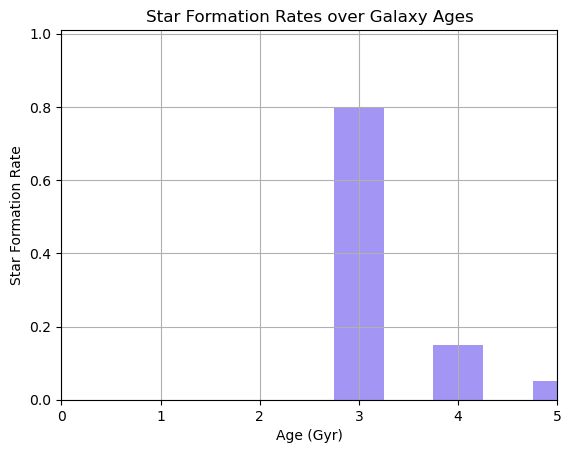

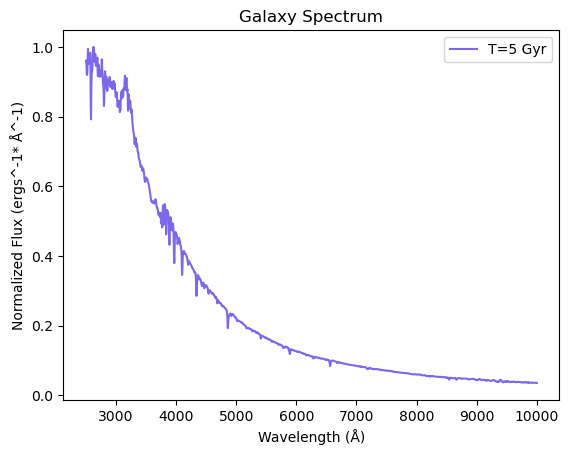

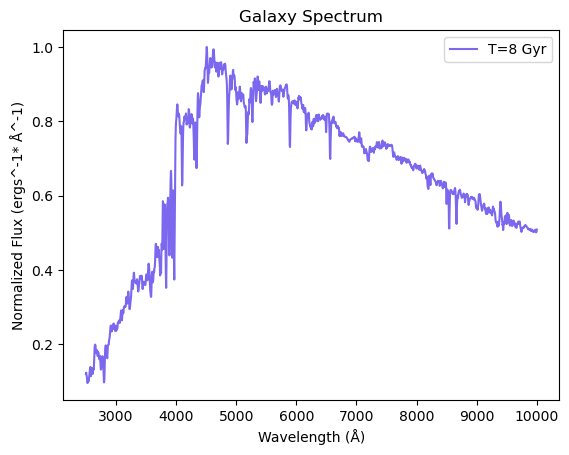

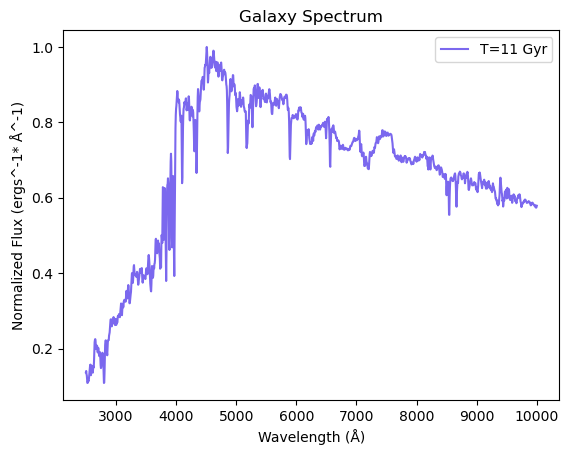

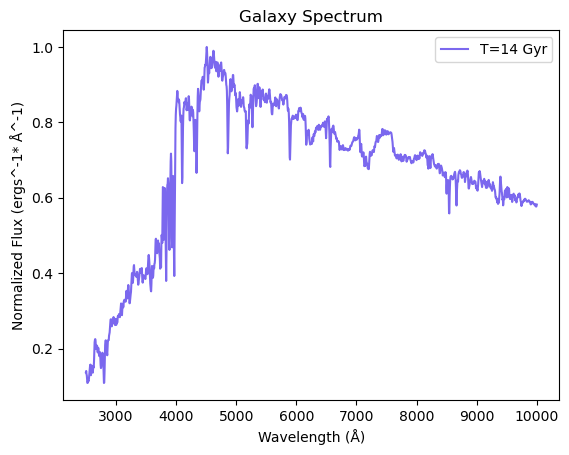

array([0.00075409, 0.00076355, 0.00075494, ..., 0.00327113, 0.00321674,
       0.0032174 ])

In [50]:
SFR_1 = [0.80, 0.15, 0.05]
t_SF_1 = [3, 4, 5]

galaxy = GALAXY(min_mass=0.1, max_mass=100)
galaxy.set_SFR(SFR_1,t_SF_1)
galaxy.plot_SFR()

galaxy.modeldisplay(SFR_1, t_SF_1)